<a href="https://colab.research.google.com/github/RoetGer/decisions-under-uncertainty/blob/main/generalized_factorization_machine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install tf2_fm_zoo

In [2]:
! git clone https://github.com/RoetGer/tf2-dist-utils.git
! pip install tf2-dist-utils/

Cloning into 'tf2-dist-utils'...
remote: Enumerating objects: 108, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 108 (delta 54), reused 84 (delta 33), pack-reused 0
Receiving objects: 100% (108/108), 14.34 KiB | 4.78 MiB/s, done.
Resolving deltas: 100% (54/54), done.
Processing ./tf2-dist-utils
  Created wheel for tf2-dist-utils: filename=tf2_dist_utils-0.0.1-cp37-none-any.whl size=5013 sha256=1067064fb1344708e2a47e588a0eaa19a0f6b1799e12f6f81de3442fc560374c
  Stored in directory: /root/.cache/pip/wheels/67/19/9a/458755d03517c7db63abf5bc1289da1648304c3cf9ef3789ba
Successfully built tf2-dist-utils


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:197: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:197: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)


Epoch 1/100
27/27 [==============================] - 1s 7ms/step - loss: 606.1400 - val_loss: 302.7391
Epoch 2/100
27/27 [==============================] - 0s 3ms/step - loss: 675.3328 - val_loss: 299.8024
Epoch 3/100
27/27 [==============================] - 0s 3ms/step - loss: 587.3767 - val_loss: 296.2664
Epoch 4/100
27/27 [==============================] - 0s 3ms/step - loss: 648.5741 - val_loss: 291.9159
Epoch 5/100
27/27 [==============================] - 0s 3ms/step - loss: 598.5106 - val_loss: 286.9246
Epoch 6/100
27/27 [==============================] - 0s 3ms/step - loss: 670.7343 - val_loss: 281.1377
Epoch 7/100
27/27 [==============================] - 0s 3ms/step - loss: 630.2023 - val_loss: 274.9049
Epoch 8/100
27/27 [==============================] - 0s 3ms/step - loss: 582.7244 - val_loss: 267.6220
Epoch 9/100
27/27 [==============================] - 0s 3ms/step - loss: 616.3528 - val_loss: 260.1917
Epoch 10/100
27/27 [==============================] - 0s 3ms/step - loss:

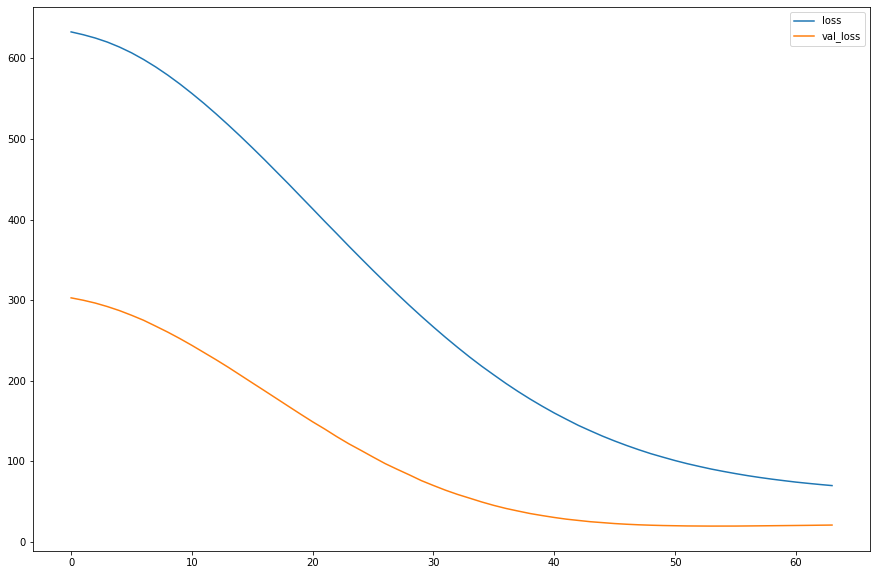

In [17]:
import tensorflow as tf
import numpy as np
import pandas as pd

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.datasets import load_boston

from fm_zoo.fm import FactorizationMachine


X, y = load_boston(return_X_y=True)

X = X[:,:3]
y = tf.cast(y, dtype=tf.float32)

kbd = KBinsDiscretizer(n_bins=15, encode="ordinal")

nunique_vals = pd.DataFrame(X).nunique()
X = tf.cast(kbd.fit_transform(X), dtype=tf.int64)

fm = FactorizationMachine(
    feature_cards=tf.cast(nunique_vals, tf.int32), 
    factor_dim=3)

fm.compile(loss=tf.keras.losses.mean_squared_error, optimizer="Adam")
hist = fm.fit(
    X, y, 
    validation_split=0.15, 
    batch_size=16,
    epochs=100,
    callbacks=[
      tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
    ])

pd.DataFrame(hist.history).plot(figsize=(15,10))

In [4]:
import tensorflow_probability as tfp
import tf2_dist_utils as tfdu
from tf2_dist_utils.distributions import TransObj
#from tf2_dist_utils.losses import 
tfd = tfp.distributions

In [32]:
import inspect
from functools import partial
from tf2_dist_utils.distributions import TransNormal

class NegLogLikeLoss(tf.keras.losses.Loss):
    '''Base class for negative loglikelihood based losses'''

    def call(self, y_true, y_pred):
        '''Computes log-probability of observations
        
        Parameters
        ----------
        y_true : tf.tensor
            Observations
        y_pred : tf.tensor
            Parameter values of the distribution underlying the loss.
        
        Returns
        -------
        tf.tensor
            Negative loglikelihood for each observation.
        '''

        shape = y_pred.shape
        '''
                if len(y_pred.shape) > 1:
                  lst = tf.split(
                    y_pred, 
                    num_or_size_splits=shape[-1], 
                    axis=(shape.ndims - 1))
                else:
                  lst = [y_pred]
        '''        
        rv = self.dist(*y_pred)#*lst)

        return -rv.log_prob(y_true)

def build_loss(class_loss_name, dist, params=None, **kwargs):
    '''Creates a tensorflow 2.x loss function based on NegLokLikeLoss

    Parameters
    ----------
    class_loss_name : str
        Name/Type of the loss to be created, e.g. "TransNormal"
    dist : distribution object
        Can be any type of tensorflow distribution object, 
        which supports parameter specification via call 
        (e.g. dist(param1, param2)) and has a log_prob method
    params : list[str]
        Specifies which parameters should be exposed for optimization
    **kwargs : dict
        kwargs can be used to fix attributes of the distribution
        object, e.g. if you want to create a loss function based on a
        Gaussian distribution with location set to 0, you can simply
        forward loc=0.0.

    Returns
    -------
    Object of type class_loss_name
        Loss object of type class_loss_name which can be used
        in conjuction with tensorflow 2.x models.
    '''
    
    if kwargs:
        dist = partial(dist, **kwargs)

    if params:
        dist = expose_params(dist, params)

    def __init__(self):
        self.dist = dist
        super(NegLogLikeLoss, self).__init__()

    loss = type(
        class_loss_name,
        (NegLogLikeLoss,),
        {
            "__init__": __init__
        }
    )

    return loss


def expose_params(func, params):
    func_header = ", ".join(params)
    func_call = ", ".join([
        p + "=" + p for p in params
    ])

    nparams = len(params)

    func_str = f'''
    class ExpParam:
      def __init__(self, func):
        self.func = func
        self.nparams = {nparams}
      
      def __call__(self, {func_header}):
          return self.func({func_call})
      
      def get_nparams(self):
          return self.nparams
    '''

    exec(inspect.cleandoc(func_str))

    return eval("ExpParam(func)")

NegGaussLogLikeLoss = build_loss("NegGaussLogLikeLoss", TransNormal)

fTransNormal = partial(TransNormal, loc=0.0)
RestrTransNormal = expose_params(fTransNormal, ["scale"])

In [42]:
ttt = build_loss("GLossScaleOnly", tfd.Normal, params=["scale"], loc=0.0)

In [19]:
RestrTransNormal(1.)

<tfp.distributions.Normal 'Normal' batch_shape=[] event_shape=[] dtype=float32>

In [18]:
inspect.signature(ttt.__call__).parameters

mappingproxy({'sample_weight': <Parameter "sample_weight=None">,
              'self': <Parameter "self">,
              'y_pred': <Parameter "y_pred">,
              'y_true': <Parameter "y_true">})

In [43]:
ttt()(y_true=[1.,2.], y_pred=tf.constant([1., 1.]))

<tf.Tensor: shape=(), dtype=float32, numpy=2.1689386>

In [39]:
y_pred = tf.constant([[1., 1.], [2., 3.]])

@tf.function()
def tfunc(y_pred):
  shape = y_pred.shape

  if len(y_pred.shape) > 1:
    lst = tf.split(
      y_pred, 
      num_or_size_splits=shape[-1], 
      axis=(shape.ndims - 1))
  else:
    lst = [y_pred]

  return lst

tfunc(y_pred)

[<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
 array([[1.],
        [2.]], dtype=float32)>, <tf.Tensor: shape=(2, 1), dtype=float32, numpy=
 array([[1.],
        [3.]], dtype=float32)>]

In [15]:
ttt(tf.constant([1.,2.,4.]), tf.constant([2., 4.,6.]))

TypeError: ignored

In [11]:
TransNormal(loc=0.0, scale=2.0).sample(10)

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([15.417641 ,  9.440426 ,  9.523952 , -2.8832717,  1.0117764,
       -5.144701 ,  2.988882 , -9.784966 , -0.3747246, 10.014172 ],
      dtype=float32)>

In [18]:
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl

class GenFactMachine():

    def __init__(self, dist, feature_cards, factor_dim):
        self.dist = dist
        self.feature_cards = feature_cards
        self.factor_dim = factor_dim
        self.n_params = len(inspect.signature(dist).parameters)

    def fit(self, X, y):
        self.loss = build_loss("GFMloss", self.dist)

        self.model = self._build_model(X)

        hist = self.model.fit(
            X, y,
            validation_split=0.15, 
            batch_size=16,
            epochs=100,
            callbacks=[
              tfk.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
            ])
        
        return hist

    def predict(self, X, y, nsamples=None):
        params = self.model.predict(X)
        
        shape = params.shape

        # model.predict returns tensor of parameters
        # dist objects are assumed to take the individual
        # columns of the tensor as input
        if len(shape) > 1:
          lst = tf.split(
            params, 
            num_or_size_splits=shape[-1], 
            axis=(shape.ndims - 1))
        else:
          lst = [params]
        
        if nsamples:
          preds = self.dist(*lst).sample(nsamples)
        else:
          preds = self.dist(*lst).mean()   

        return preds

    def _build_model(self, X):

        inputs_ = tfk.Input(shape=X.shape[1])

        self.fms = [
            FactorizationMachine(
              feature_cards=self.feature_cards, 
              factor_dim=self.factor_dim)
            for _ in range(self.n_params)        
        ]

        params = [
            fm(inputs_) for fm in self.fms          
        ]
        params = tfkl.Concatenate(params)

        model = tfk.Model(inputs=inputs_, outputs=params)

        model.compile(
            loss=self.loss,
            optimizer=keras.optimizers.RMSprop())
        
        return model

In [33]:
dist=TransNormal
feature_cards=tf.cast(nunique_vals, tf.int32)
factor_dim=3
n_params = 2

loss = build_loss("GFMloss", dist)

inputs_ = tfk.Input(shape=X.shape[1], dtype=X.dtype)

fms = [
    FactorizationMachine(
      feature_cards=feature_cards, 
      factor_dim=factor_dim,
      name="sub_mdl_" + str(i))
    for i in range(n_params)        
]

params = [
    fm(inputs_) for fm in fms          
]
#params = tfkl.Concatenate(params)

model = tfk.Model(inputs=inputs_, outputs=params)

model.compile(
    loss=loss,
    optimizer=tfk.optimizers.RMSprop())

In [34]:
model.fit(X, y)

TypeError: ignored

In [19]:
X, y = load_boston(return_X_y=True)

X = X[:,:3]
y = tf.cast(y, dtype=tf.float32)

kbd = KBinsDiscretizer(n_bins=15, encode="ordinal")

nunique_vals = pd.DataFrame(X).nunique()
X = tf.cast(kbd.fit_transform(X), dtype=tf.int64)

gfm = GenFactMachine(
    dist=TransNormal,
    feature_cards=tf.cast(nunique_vals, tf.int32), 
    factor_dim=3)



hist = gfm.fit(X, y)

pd.DataFrame(hist.history).plot(figsize=(15,10))

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:197: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:197: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)


TypeError: ignored

In [ ]:
        def obj_func():
            params = [
               fm(X) for fm in self.fms
            ]
            ll = tfd.Normal(loc=mu, scale=sigma).log_prob(y)
            return -tf.reduce_sum(ll)

            return 

        opt_info = tfp.math.minimize(
          lambda: obj_func(), 
          num_steps=1000, 
          optimizer=tf.optimizers.Adam(learning_rate=0.1),
          return_full_length_trace=False,
          convergence_criterion=(
            tfp.optimizer.convergence_criteria.LossNotDecreasing(
                atol=0.0001, rtol=0.0001)))

In [7]:
tf.reduce_mean(RestrTransNormal(1.).sample(1000)**2)

<tf.Tensor: shape=(), dtype=float32, numpy=7.942813>

In [21]:
        def obj_func():
            params = [
               fm(X) for fm in self.fms
            ]
            ll = tfd.Normal(loc=mu, scale=sigma).log_prob(y)
            return -tf.reduce_sum(ll)

            return 

        opt_info = tfp.math.minimize(
          lambda: obj_func(), 
          num_steps=1000, 
          optimizer=tf.optimizers.Adam(learning_rate=0.1),
          return_full_length_trace=False,
          convergence_criterion=(
            tfp.optimizer.convergence_criteria.LossNotDecreasing(
                atol=0.0001, rtol=0.0001)))

1

In [27]:
def func(dist, **kwargs):
    return partial(dist, **kwargs)

func(tfd.Normal, loc=0.0)(scale=2.0)

<tfp.distributions.Normal 'Normal' batch_shape=[] event_shape=[] dtype=float32>

Epoch 1/50
16/16 [==============================] - 1s 1ms/step - loss: 1.6209
Epoch 2/50
16/16 [==============================] - 0s 2ms/step - loss: 1.4831
Epoch 3/50
16/16 [==============================] - 0s 1ms/step - loss: 1.2880
Epoch 4/50
16/16 [==============================] - 0s 2ms/step - loss: 1.1223
Epoch 5/50
16/16 [==============================] - 0s 2ms/step - loss: 1.1587
Epoch 6/50
16/16 [==============================] - 0s 1ms/step - loss: 0.9622
Epoch 7/50
16/16 [==============================] - 0s 2ms/step - loss: 0.9979
Epoch 8/50
16/16 [==============================] - 0s 1ms/step - loss: 0.9115
Epoch 9/50
16/16 [==============================] - 0s 2ms/step - loss: 1.0340
Epoch 10/50
16/16 [==============================] - 0s 1ms/step - loss: 0.9856
Epoch 11/50
16/16 [==============================] - 0s 1ms/step - loss: 1.0410
Epoch 12/50
16/16 [==============================] - 0s 1ms/step - loss: 0.9986
Epoch 13/50
16/16 [==============================

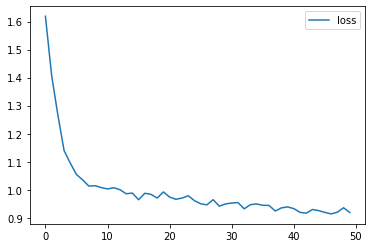

In [ ]:
mdl = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(5)),
    tf.keras.layers.Dense(10, activation=tf.keras.layers.LeakyReLU()),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1)                            
])

mdl.compile(
    loss="mse",
    optimizer="rmsprop")

inp = tf.random.normal(shape=(500,5))
target = tf.random.normal(shape=(500,1))

hist = mdl.fit(inp, target, batch_size=32, epochs=50)
pd.DataFrame(hist.history).plot()

In [ ]:
fm.predict(X)

array([[0.48257238],
       [0.55737823],
       [0.55737823],
       [0.5582001 ],
       [0.6179424 ],
       [0.5582001 ],
       [0.49677452],
       [0.50840414],
       [0.55747545],
       [0.55747545],
       [0.49024242],
       [0.50840414],
       [0.49677452],
       [0.4901852 ],
       [0.4901852 ],
       [0.4901852 ],
       [0.4901852 ],
       [0.4901852 ],
       [0.4901852 ],
       [0.4901852 ],
       [0.54042417],
       [0.4901852 ],
       [0.54042417],
       [0.4901852 ],
       [0.4901852 ],
       [0.4901852 ],
       [0.4901852 ],
       [0.4901852 ],
       [0.4901852 ],
       [0.4901852 ],
       [0.4901852 ],
       [0.54042417],
       [0.54042417],
       [0.4901852 ],
       [0.54042417],
       [0.5948064 ],
       [0.5136728 ],
       [0.5948064 ],
       [0.57338154],
       [0.5028088 ],
       [0.54654753],
       [0.543584  ],
       [0.543584  ],
       [0.5930207 ],
       [0.543584  ],
       [0.5930207 ],
       [0.5930207 ],
       [0.524

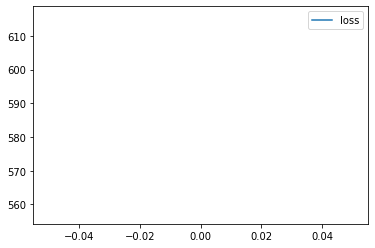

In [ ]:
pd.DataFrame(hist.history).plot()

In [ ]:
fm(tf.cast(X, dtype=tf.int64))

<tf.Tensor: shape=(506, 1), dtype=float32, numpy=
array([[0.2919633 ],
       [0.25897792],
       [0.25897792],
       [0.22296599],
       [0.24901795],
       [0.22296599],
       [0.24353305],
       [0.230096  ],
       [0.21192904],
       [0.21192904],
       [0.296324  ],
       [0.230096  ],
       [0.24353305],
       [0.33529255],
       [0.33529255],
       [0.33529255],
       [0.33529255],
       [0.33529255],
       [0.33529255],
       [0.33529255],
       [0.29218113],
       [0.33529255],
       [0.29218113],
       [0.33529255],
       [0.33529255],
       [0.33529255],
       [0.33529255],
       [0.33529255],
       [0.33529255],
       [0.33529255],
       [0.33529255],
       [0.29218113],
       [0.29218113],
       [0.33529255],
       [0.29218113],
       [0.2762244 ],
       [0.26572493],
       [0.2762244 ],
       [0.23570503],
       [0.28262508],
       [0.29581124],
       [0.26099578],
       [0.26099578],
       [0.24189958],
       [0.26099578],
     

In [ ]:
a, b = np.unique(X, return_counts=True)

In [ ]:
X

<tf.Tensor: shape=(506, 3), dtype=float32, numpy=
array([[0., 0., 1.],
       [0., 0., 5.],
       [0., 0., 5.],
       ...,
       [2., 0., 8.],
       [4., 0., 8.],
       [2., 0., 8.]], dtype=float32)>